#notebooks.QBM_1d
Sample generation from a beta distribution using the quantum Born machine. Essentially a fork of https://github.com/GiggleLiu/QuantumCircuitBornMachine to adapt the methodology in https://arxiv.org/abs/1804.04168 for the current project.

## Setup

In [1]:
import os
os.chdir('generative_models_via_sqsp')

In [2]:
from config import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import beta

## QBM

### Globals

In [4]:
#Pauli Matrices
I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

#Projectors
p0 = (sz + I2) / 2
p1 = (-sz + I2) / 2

### Utilities

In [5]:
def rot_matrix(si, theta):
    """
    Single qubit rotation
    """
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return rot_matrix(sz, t3).dot(rot_matrix(sx, t2)).dot(rot_matrix(sz, t1))

def CNOT(ibit, jbit, n):
    '''
    CNOT gate

    Args:
        ibit (int): control bit.
        jbit (int): controled bit.
        n (int): total number of qubits.

    Returns:
        4x4 csr_matrix: CNOT matrix.
    '''
    res = compiler([p0, I2], [ibit, jbit], n)
    res = res + compiler([p1, sx], [ibit, jbit], n)
    return res

def compiler(ops, locs, n):
    '''
    Compile operators into specific Hilbert space.

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.

    Remark: the last bit is the high end bit
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return wrap_identity([ops[i] for i in order], np.diff(locs) - 1)

def wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res

def initial_wf(num_bit):
    '''initial wave function |00...0>.'''
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrices update method.

    Args:
        layer (ArbitraryRotation): rotation layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        list of csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]
    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    new = old[:]
    new[isite] = compiler(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new

In [6]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs (CNOTs are applied to these pairs).'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_circuit(num_bit, depth, pairs):
    '''Get the circuit used for demo'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))
    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

def mix_rbf_kernel(x, y, sigma_list):
    '''
    multi-RBF kernel.

    Args:
        x (1darray|2darray): the collection of samples A.
        x (1darray|2darray): the collection of samples B.
        sigma_list (list): a list of bandwidths.

    Returns:
        2darray: kernel matrix.
    '''
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

def sample_from_prob(x, pl, num_sample):
    '''
    sample x ~ pl.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])

def prob_from_sample(dataset, hndim):
    '''
    emperical probability from data.
    '''
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.

    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('Adam'|'L-BFGS-B'):
            * L-BFGS-B: efficient, but not noise tolerant.
            * Adam: noise tolerant.
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.

    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))

    theta_list = np.array(theta_list)
    if method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

### classes

In [7]:
class ArbitraryRotation(object):
    '''Arbitrary rotation gate'''
    def __init__(self, num_bit):
        self.num_bit = num_bit
        # mask is used to filter out some irrelevant (marked False) parameters
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [compiler([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res


class CNOTEntangler(object):
    '''
    CNOT Entangler Layer.

    Args:
        pairs (list): a list of tuples to represent connections.
    '''
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

In [8]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.

    Attributes:
        theta_last (1darray): the cached circuit parameters.
        memo (list): cached sparse matrices for layers.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        '''
        Apply operations on vector basis: qureg. This operation changes vector inplace.

        Args:
            qureg (1darray): vector basis.
            theta_list (1darray): circuit parameters:
        '''
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)

    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

In [9]:
class RBFMMD2(object):
    '''
    MMD^2 with RBF (Gaussian) kernel.

    Args:
        sigma_list (list): a list of bandwidths.
        basis (1darray): defininng space.

    Attributes:
        K (2darray): full kernel matrix, notice the Hilbert space is countable.
    '''
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float: loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        '''
        expectation value of kernel function.

        Args:
            px (1darray): the first PDF.
            py (1darray): the second PDF.

        Returns:
            float: kernel expectation.
        '''
        return px.dot(self.K).dot(py)

In [10]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine framework,

    Args:
        circuit (BlockQueue): the circuit architechture.
        mmd (RBFMMD2): maximum mean discrepancy.
        p_data (1darray): data probability distribution in computation basis.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        '''defined by the number of entanglers'''
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''
        get probability distribution function.

        Args:
            theta_list (1darray): circuit parameters.

        Returns:
            1darray: probability distribution function.
        '''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = np.abs(wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl))
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)

## Test

In [11]:
alpha = 2
beta_ = 2
m = 4
depth = 1
a = 0
b = 1

In [12]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_)
p_i_set /= p_i_set.sum()

In [13]:
pairs = get_nn_pairs(m)
circuit = get_circuit(m, depth, pairs)
mmd = RBFMMD2(sigma_list=[1,2], basis=np.arange(2**m))#[0.25,4]
bm = QCBM(circuit, mmd, p_i_set, batch_size=None)

In [16]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
#loss, theta_list = train(bm, theta_list, 'COBYLA', max_iter=9)
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=10)
pl = bm.pdf(theta_list)

step = 1, loss = 0.06703623923771243
step = 2, loss = 0.02224518168284447
step = 3, loss = 0.018138005331493273
step = 4, loss = 0.006892527803166158
step = 5, loss = 0.004571341702567294
step = 6, loss = 0.002400075950759994
step = 7, loss = 0.0021155669299491187
step = 8, loss = 0.0019393854780476623
step = 9, loss = 0.0017852800394163506
step = 10, loss = 0.001704930214912065


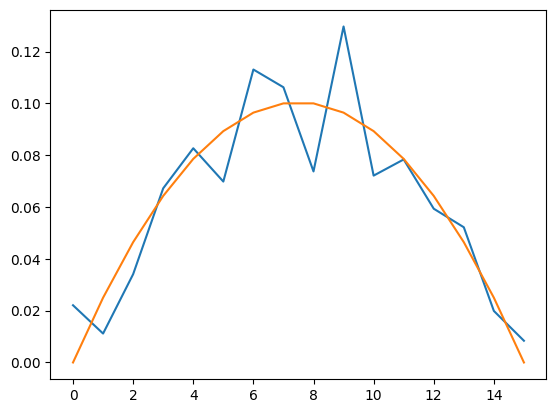

In [17]:
plt.plot(pl)
plt.plot(p_i_set)